# Value in equities

#### by Gustavo Soares

In this notebook you will apply a few things you learned in our Python lecture [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, date variables, floats, dictionaries, lists, list comprehensions, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements and loops, and;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a Bloomberg terminal. If you are using this notebook within BQNT, you may want to use BQL for getting the data.

## Basic imports

You can use BQuant and BQL to download data like we did in our [notebook on K-means clustering](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/kmeans_clusters_factors.ipynb). Here, we will use the standard terminal [FinanceHub's Python API](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) to grab the data but I encourage you to try it all out with the BQuant + BQL combo!

In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bloomberg import BBG
bbg = BBG() # because BBG is a class, we need to create an instance of the BBG class wihtin this notebook, here deonted by bbg

## Value metrics: cross-sectional implementation

Value investing is an investment strategy that involves picking stocks that appear to be trading for less than their intrinsic or book value. Numerous studies document that value stocks, loosely defined as stocks with low prices relative to earnings, dividends, or book value, generate higher long-run returns than growth stocks, or stocks with high prices relative to these measures of fundamental value. The chapter on *Value Premium* of [Empirical Asset Pricing: The Cross Section of Stock Returns](https://www.amazon.com/Empirical-Asset-Pricing-Probability-Statistics/dp/1118095049) has a great summary of the academic finding regarding value strategies in equities. Here, we will focus on creating a value metric for a stock or set of stocks.

Going back to 1992 [Fama and French Three-Factor Model](https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp) cross-sectional value strategies are considered one of the risk factors to be added to the CAPM market risk factor. In our own [notebook on K-means clustering](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/kmeans_clusters_factors.ipynb) we construct a value metric based on the Book-to-Price ratio for comparing stocks cross-sectionally. Here, we also discuss defining a value metric in a cross-sectional sense a bit more.

### Book-to-Price

The book-to-price or book-to-market ratio, is defined as the book value of a firm’s common equity (BE) divided by the market value of the firm’s equity (ME), or where the book value comes from the firm’s balance sheet and the market value is identical to the market capitalization of the firm. The price-to-book ratio is a close cousin of Tobin's Q, another statistic used by investors to gauge value in stocks. Tobin's Q is defined as the ratio of the market cap to the replacement cost of assets. A Q that is greater than 1 means that an investor is better off replicating the assets of a company rather than buying it. It indicates that a company is expensive. Similarly, high price-to-book ratios are a presumption of expensiveness.

The code below downloads the stocks belonging to IBOVESP, the Brazilian stock index and grabs their price to book ratio:

In [2]:
ref_date = '2019-12-04'
w_df = bbg.fetch_index_weights(index_name='IBOV Index', ref_date=pd.to_datetime(ref_date))
list_of_tickers = [x + ' Equity' for x in w_df.index]
w_df.index = list_of_tickers
sectors = bbg.fetch_contract_parameter(securities=list_of_tickers, field='GICS_SECTOR_NAME')

price_to_book = bbg.fetch_series(securities=list_of_tickers,
                               fields='PX_TO_BOOK_RATIO',
                               startdate=ref_date,
                               enddate=ref_date)
df = pd.concat([w_df.iloc[:,0].to_frame('weights'),
                price_to_book.iloc[0].to_frame('price_to_book'),
                sectors.iloc[:,0].to_frame('sector')],axis=1,sort=True)
df.sort_values(by='weights',ascending=False).head()

,weights,price_to_book,sector
ITUB4 BS Equity,9.093481,2.7482,Financials
VALE3 BS Equity,8.413275,1.4545,Materials
PETR4 BS Equity,7.037279,1.2461,Energy
BBDC4 BS Equity,7.026929,1.9744,Financials
B3SA3 BS Equity,5.234786,3.9505,Financials


One way of computing the value metric for a value strategy is comparing it with its peers. Here, the Global Industry Classification Standard (GICS) sectors to define the peer group but you can think of [more sophisticated ways](https://www.winton.com/research/systematic-methods-for-classifying-equities) of doing that if you want.

How do we compare the value metric with the peer-group? A traditional way of doing that is using z-scores. Even when using z-scores, it's common for people to [winsorize](https://en.wikipedia.org/wiki/Winsorizing) z-scores. Here, we do that at the 0.1 limits

In [3]:
df['book_to_price_scores'] = np.nan
for s in set(df['sector']):
    signals = df[df['sector']==s]['price_to_book'].dropna()**-1 # the inverse because we want B/P and not P/B
    if len(signals)>=5:        
        df.loc[signals.index,'book_to_price_scores'] = stats.mstats.winsorize(stats.zscore(signals.values), limits=.1)
df = df.dropna()
df.head(10)

,weights,price_to_book,sector,book_to_price_scores
ABEV3 BS Equity,4.172774,4.266,Consumer Staples,-0.169934
B3SA3 BS Equity,5.234786,3.9505,Financials,-0.987511
BBAS3 BS Equity,3.599393,1.3333,Financials,2.03108
BBDC3 BS Equity,1.890980,1.8349,Financials,0.785518
BBDC4 BS Equity,7.026929,1.9744,Financials,0.551595
BBSE3 BS Equity,1.272964,6.5793,Financials,-1.60194
BPAC11 BS Equity,0.722813,2.9043,Financials,-0.433564
BRAP4 BS Equity,0.401519,1.1506,Materials,0.295421
BRDT3 BS Equity,1.058676,3.3045,Consumer Discretionary,-0.015279
BRFS3 BS Equity,1.550324,4.1326,Consumer Staples,-0.122568


### Dividend yields

[Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://ssrn.com/abstract=2695101) discusses how dividend yields can also be used as a measure of value for broad equity markets. High dividend yields may indicate that stocks are cheap against bonds for example. Companies pay dividends to their shareholders but they, from time to time, also buy back stock from them. When a company buys back shares from its shareholders, it reduces the number of shares outstanding, which increases per share measures of profitability like EPS, Cash Flow Per Share, ROE. These improved metrics generally drives the share price higher over time. Hence to account for these changes, it is common to updated the yield measure to account for both dividends and buybacks. Here, to make things simple, we do not do that.

In [4]:
dvd_yield = bbg.fetch_series(securities=list(df.index),
                               fields='EQY_DVD_YLD_IND',
                               startdate=ref_date,
                               enddate=ref_date)

df = pd.concat([df,dvd_yield.iloc[0].to_frame('dvd_yield')],axis=1,sort=True)
for s in set(df['sector']):
    signals = df[df['sector']==s]['dvd_yield'].dropna()
    if len(signals)>=5:        
        df.loc[signals.index,'dvd_yield_scores'] = stats.mstats.winsorize(stats.zscore(signals.values), limits=.1)
df = df.dropna()

### Earnings yields

The earnings yield refers to the earnings per share for the most recent 12-month period divided by the current market price per share. The earnings yield (which is the inverse of the P/E ratio) shows the percentage of how much a company earned per share. 

In [5]:
earnings_yield = bbg.fetch_series(securities=list(df.index),
                               fields='EARN_YLD',
                               startdate=ref_date,
                               enddate=ref_date)

df = pd.concat([df,earnings_yield.iloc[0].to_frame('earnings_yield')],axis=1,sort=True)
for s in set(df['sector']):
    signals = df[df['sector']==s]['earnings_yield'].dropna()
    if len(signals)>=5:        
        df.loc[signals.index,'earnings_yield_scores'] = stats.mstats.winsorize(stats.zscore(signals.values), limits=.1)
df = df.dropna()

### Cash flow yields

The cash flow yield is calculated by taking the free cash flow per share divided by the current share price. Free cash flow yield is similar in nature to the earnings yield metric above, which is usually meant to measure GAAP (generally accepted accounting principles) earnings per share divided by share price.

In [6]:
cf_yield = bbg.fetch_series(securities=list(df.index),
                               fields='FREE_CASH_FLOW_YIELD',
                               startdate=ref_date,
                               enddate=ref_date)

df = pd.concat([df,cf_yield.iloc[0].to_frame('cf_yield')],axis=1,sort=True)
for s in set(df['sector']):
    signals = df[df['sector']==s]['cf_yield'].dropna()
    if len(signals)>=5:        
        df.loc[signals.index,'cf_yield_scores'] = stats.mstats.winsorize(stats.zscore(signals.values), limits=.1)
df = df.dropna()

## Combining metrics

In cross-sectional as well as in time-series implementations, typically, combining different metrics has been found in empirical studies to produce better forecasts on average than methods based on the ex ante best individual metric. Even simple combinations that ignore correlations between metrics often dominate more refined combination schemes aimed at estimating the theoretically optimal combination weights. Although the reasons for the success of simple combination schemes are poorly understood (model misspecification, non-stationarities, regime switches, etc.). This [book chapter](https://www.sciencedirect.com/science/article/abs/pii/S1574070605010049) is a great reference for forecast combinations if you want to learn more about it. Here, we combine the four cross-sectional value metrics discussed above into a signle value metric using a simple average:

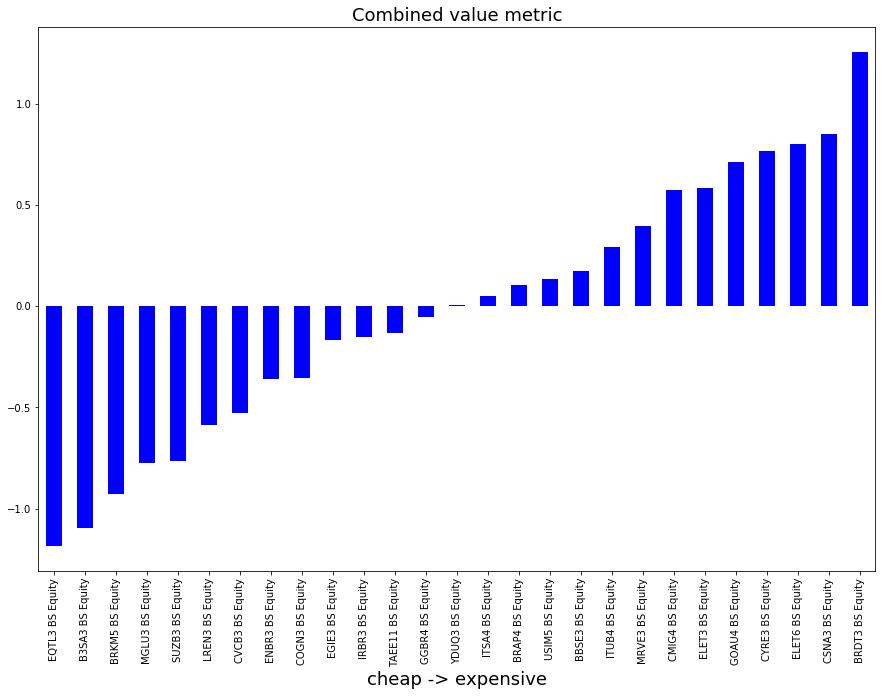

In [7]:
zscores_df = df[['book_to_price_scores','dvd_yield_scores','earnings_yield_scores','cf_yield_scores']].astype(float)
zscores_df['value_metric'] = zscores_df.mean(axis=1)
zscores_df['value_metric'].sort_values().plot(kind='bar',color='b',figsize=(15,10))
plt.title('Combined value metric',fontsize=18)
plt.xlabel('cheap -> expensive',fontsize=18)
plt.show()

Using this metric, we can think of a strategy that goes long the cheap stocks (say the 20% cheapest ones) and short the expensive stocks say the 20% most expensive ones)

In [8]:
cheap_list = zscores_df[zscores_df['value_metric']<=zscores_df['value_metric'].quantile(q=0.20)].index
print('Go long:')
print(list(cheap_list))
expensive_list = zscores_df[zscores_df['value_metric']>=zscores_df['value_metric'].quantile(q=0.80)].index
print('Go short:')
print(list(expensive_list))

Go long:
['B3SA3 BS Equity', 'BRKM5 BS Equity', 'EQTL3 BS Equity', 'LREN3 BS Equity', 'MGLU3 BS Equity', 'SUZB3 BS Equity']
Go short:
['BRDT3 BS Equity', 'CSNA3 BS Equity', 'CYRE3 BS Equity', 'ELET3 BS Equity', 'ELET6 BS Equity', 'GOAU4 BS Equity']


## Value metrics: time-series implementation

[Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://ssrn.com/abstract=2695101) discusses in detail the differences between cross-sectional strategies and time series strategies for three different factors, including value. It is really important to understand the difference between the two implementations. The key difference is that now, we will look at value of a particular stock but not compare it with its peers but rather with its own historical measures. To illustrate, let's pick one particular stock, say ITUB4.

Let's start by grabbing the data we are going to need from Bloomberg:

In [9]:
ts_data = bbg.fetch_series(securities='ITUB4 BS Equity',
                               fields=['PX_LAST','PX_TO_BOOK_RATIO','EQY_DVD_YLD_IND','EARN_YLD','FREE_CASH_FLOW_YIELD'],
                               startdate='2010-01-01',
                               enddate=ref_date)
ts_data = ts_data.dropna().astype(float)
ts_data.tail()

,PX_LAST,PX_TO_BOOK_RATIO,EQY_DVD_YLD_IND,EARN_YLD,FREE_CASH_FLOW_YIELD
2019-11-28,34.519,2.5997,0.5215,7.4686,25.7829
2019-11-29,34.718,2.6148,0.5185,7.4257,25.6347
2019-12-02,35.212,2.6520,0.5112,7.3215,25.2750
2019-12-03,35.222,2.6527,0.5110,7.3194,25.2679
2019-12-04,36.490,2.7482,0.4933,7.0651,24.3901


Note that the quality of the data is not the best. This is often a serious problem when constructing quant strategies. Most of the time and effort is dedicated to cleaning data:

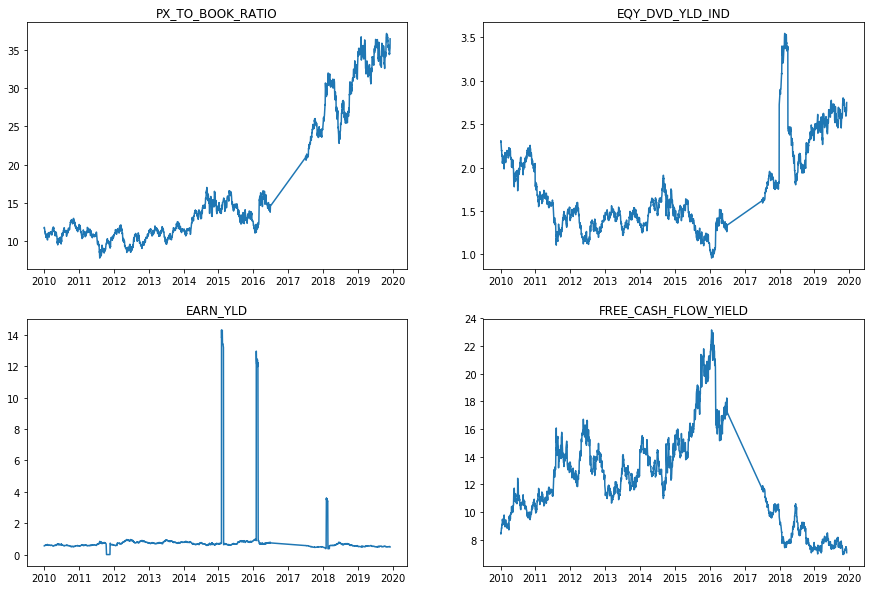

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
axs[0, 0].plot(ts_data.iloc[:,0].dropna().index, ts_data.iloc[:,0].dropna().values)
axs[0, 0].set_title(ts_data.columns[1])
axs[0, 1].plot(ts_data.iloc[:,1].dropna().index, ts_data.iloc[:,1].dropna().values)
axs[0, 1].set_title(ts_data.columns[2])
axs[1, 0].plot(ts_data.iloc[:,2].dropna().index, ts_data.iloc[:,2].dropna().values)
axs[1, 0].set_title(ts_data.columns[3])
axs[1, 1].plot(ts_data.iloc[:,3].dropna().index, ts_data.iloc[:,3].dropna().values)
axs[1, 1].set_title(ts_data.columns[4])
plt.show()

Here, we are not going to directly deal with the bad data. We will just trucate at one year:

In [11]:
ts = ts_data.iloc[-252:,:]
ts.iloc[:,1] = ts.iloc[:,1]**-1 # the inverse because we want B/P and not P/B
ts = ts.rename(columns={"PX_TO_BOOK_RATIO": "BOOK_TO_PX_RATIO"})

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Let's now calcualte time series z-scores. Note that we need to do that by looking back in the stocks past historical data and calculating z-scores with the information that was available at that point in time. The method `rolling` from `Pandas` is a great way to do that:

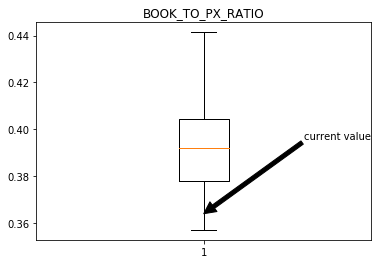

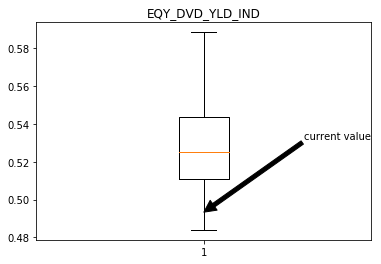

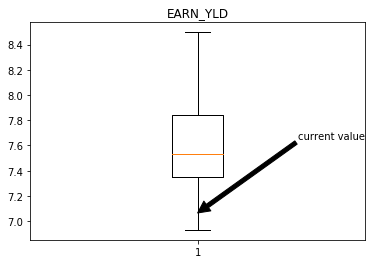

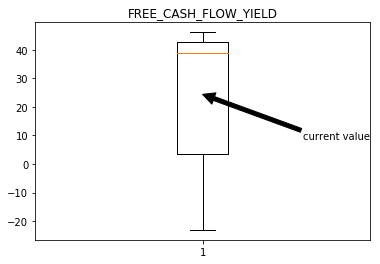

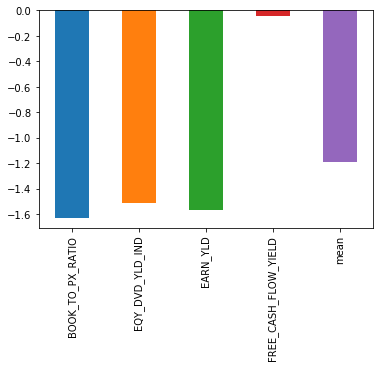

In [12]:
for i in range(1,5):
    fig1, ax1 = plt.subplots()
    ax1.set_title(ts.columns[i])
    ax1.boxplot(ts.iloc[:,i])
    ax1.annotate('current value', xy=(1, ts.iloc[-1,i]),  xycoords='data',
                xytext=(1, 0.5), textcoords='axes fraction',
                arrowprops=dict(facecolor='black'),
                horizontalalignment='right', verticalalignment='top',
                )
    plt.show()
    
zscores = (ts.iloc[-1,1:]-ts.iloc[:,1:].mean())/ts.iloc[:,1:].std()
zscores['mean'] = zscores.mean()
zscores.plot(kind='bar')

So, relative to its own history, it seems like this stock is expensive!

## Exercises

#### Beginners

Try to calculate a cross-sectional or time-series value metric that takes into account the fact that different metrics may have different volatilities, they may be correlated with each other, they may have different forecasting errors and different halflives.

#### Intermediate

Calculate a time series value strategies as in  [Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://www.cmegroup.com/education/files/dissecting-investment-strategies-in-the-cross-section-and-time-series.pdf).


#### Intermediate

Create a class to calculate time-series value mterics for one stock.

#### Advanced

Create a class to calculate both cross-sectional and time-series value for a set of stock.

#### Jedi Master

Carry out the Advanced task above and make a contribution to [FinanceHub's signals class](https://github.com/Finance-Hub/FinanceHub/tree/master/signals).